https://www.kaggle.com/c/state-farm-distracted-driver-detection  

based on prev work by bmt.
Kaggle-dogs-cats-kernel/Kaggle-cats-dogs-redux-ensemble-1-load-data-model-predict.ipynb

In [1]:
sample_or_prod = True #True = sample, False = production
batch_size=64

c0: safe driving  
c1: texting - right  
c2: talking on the phone - right  
c3: texting - left  
c4: talking on the phone - left  
c5: operating the radio  
c6: drinking  
c7: reaching behind  
c8: hair and makeup  
c9: talking to passenger  

In [2]:
HOMEPATH = "/home/ubuntu/fastai/"
DATA_PATH = HOMEPATH + "data/state/"
print("HOMEPATH:", HOMEPATH)
print("DATA_PATH:", DATA_PATH)
import os
from __future__ import division, print_function


('HOMEPATH:', '/home/ubuntu/fastai/')
('DATA_PATH:', '/home/ubuntu/fastai/data/state/')


In [3]:
import os
from datetime import datetime
from glob import glob
from random import shuffle
from shutil import copyfile
import pandas as pd
import numpy as np
import random
import cv2

In [4]:
MODEL_PATH = DATA_PATH+"models/"
RESULTS_PATH = DATA_PATH+"results/"


SAMPLE_DATA_PATH = DATA_PATH + "sample/"#choose this for testing or above for production
SAMPLE_TEST_PATH = SAMPLE_DATA_PATH+"test/"
SAMPLE_TRAIN_PATH = SAMPLE_DATA_PATH + "train/"
SAMPLE_VALID_PATH = SAMPLE_DATA_PATH + "valid/"


TEST_PATH = DATA_PATH+"test/"
TRAIN_PATH = DATA_PATH + "train/"
VALID_PATH = DATA_PATH + "valid/"


if sample_or_prod:
    WORKING_DATA  = SAMPLE_DATA_PATH
    WORKING_TEST  = SAMPLE_TEST_PATH
    WORKING_TRAIN = SAMPLE_TRAIN_PATH
    WORKING_VALID = SAMPLE_VALID_PATH
    s_or_p = "_sample_"
else:
    WORKING_DATA  = DATA_PATH
    WORKING_TEST  = TEST_PATH
    WORKING_TRAIN = TRAIN_PATH
    WORKING_VALID = VALID_PATH
    s_or_p = "_prod_"

    
print ("WORKING_DATA:", WORKING_DATA)
print ("WORKING_TEST:", WORKING_TEST)
print ("WORKING_TRAIN:", WORKING_TRAIN)
print ("WORKING_VALID:", WORKING_VALID)
print ("s_or_p:", s_or_p)

WORKING_DATA: /home/ubuntu/fastai/data/state/sample/
WORKING_TEST: /home/ubuntu/fastai/data/state/sample/test/
WORKING_TRAIN: /home/ubuntu/fastai/data/state/sample/train/
WORKING_VALID: /home/ubuntu/fastai/data/state/sample/valid/
s_or_p: _sample_


In [5]:
os.chdir(DATA_PATH)
print (os.getcwd())
!tree -d

/home/ubuntu/fastai/data/state
.
├── models
├── results
├── sample
│   ├── test
│   │   └── unknown
│   ├── train
│   │   ├── c0
│   │   ├── c1
│   │   ├── c2
│   │   ├── c3
│   │   ├── c4
│   │   ├── c5
│   │   ├── c6
│   │   ├── c7
│   │   ├── c8
│   │   └── c9
│   └── valid
│       ├── c0
│       ├── c1
│       ├── c2
│       ├── c3
│       ├── c4
│       ├── c5
│       ├── c6
│       ├── c7
│       ├── c8
│       └── c9
├── test
│   └── unknown
├── train
│   ├── c0
│   ├── c1
│   ├── c2
│   ├── c3
│   ├── c4
│   ├── c5
│   ├── c6
│   ├── c7
│   ├── c8
│   └── c9
└── valid
    ├── c0
    ├── c1
    ├── c2
    ├── c3
    ├── c4
    ├── c5
    ├── c6
    ├── c7
    ├── c8
    └── c9

51 directories


In [6]:
def dirFileList(dir_path):
    return [name for name in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, name))]


In [7]:
CATEGORIES = []


for i in range(10):
    CATEGORIES.append("c"+str(i)+"/")
print ("CATEGORIES:", CATEGORIES)

CATEGORIES: ['c0/', 'c1/', 'c2/', 'c3/', 'c4/', 'c5/', 'c6/', 'c7/', 'c8/', 'c9/']


In [8]:
UNKNOWN = 'unknown/'

DATA_DIR_LIST = [DATA_PATH, SAMPLE_DATA_PATH, SAMPLE_TEST_PATH, SAMPLE_TEST_PATH+UNKNOWN, SAMPLE_TRAIN_PATH, 
                 SAMPLE_VALID_PATH, TEST_PATH, TEST_PATH+UNKNOWN, TRAIN_PATH, VALID_PATH, MODEL_PATH, RESULTS_PATH]



for category in CATEGORIES:
    DATA_DIR_LIST.append(TRAIN_PATH+category)
    DATA_DIR_LIST.append(VALID_PATH+category)
    DATA_DIR_LIST.append(SAMPLE_TRAIN_PATH+category)
    DATA_DIR_LIST.append(SAMPLE_VALID_PATH+category)

In [9]:
def showLayersInfo(model):
    print ("Number of layers : ", len(model.layers))
    count = 0
    for layer in model.layers:
        print (count, type(layer), ", trainable:", layer.trainable)
        print ("input:", layer.input_shape, ", output:",layer.output_shape, ", len(weights)", len(layer.get_weights()), "\n")
        count +=1

In [10]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()

In [11]:
def listDirsFileCount(DATA_DIR_LIST):
    DATA_DIR_LIST = sorted(DATA_DIR_LIST)
    for dir_ in DATA_DIR_LIST:
        print (dir_, len(dirFileList(dir_)))
        
#NB: could have used global DATA_DIR_LIST  to access global variable DATA_DIR_LIST 
# without having to pass DATA_DIR_LIST as an arg, but this gives more flexability.

In [12]:
listDirsFileCount(DATA_DIR_LIST)

/home/ubuntu/fastai/data/state/ 5
/home/ubuntu/fastai/data/state/models/ 0
/home/ubuntu/fastai/data/state/results/ 2
/home/ubuntu/fastai/data/state/sample/ 0
/home/ubuntu/fastai/data/state/sample/test/ 0
/home/ubuntu/fastai/data/state/sample/test/unknown/ 15945
/home/ubuntu/fastai/data/state/sample/train/ 0
/home/ubuntu/fastai/data/state/sample/train/c0/ 347
/home/ubuntu/fastai/data/state/sample/train/c1/ 314
/home/ubuntu/fastai/data/state/sample/train/c2/ 323
/home/ubuntu/fastai/data/state/sample/train/c3/ 325
/home/ubuntu/fastai/data/state/sample/train/c4/ 323
/home/ubuntu/fastai/data/state/sample/train/c5/ 322
/home/ubuntu/fastai/data/state/sample/train/c6/ 324
/home/ubuntu/fastai/data/state/sample/train/c7/ 278
/home/ubuntu/fastai/data/state/sample/train/c8/ 268
/home/ubuntu/fastai/data/state/sample/train/c9/ 298
/home/ubuntu/fastai/data/state/sample/valid/ 0
/home/ubuntu/fastai/data/state/sample/valid/c0/ 153
/home/ubuntu/fastai/data/state/sample/valid/c1/ 138
/home/ubuntu/fastai/

In [13]:
os.chdir(HOMEPATH)
print ("current working directory:", os.getcwd())

%matplotlib inline
from __future__ import print_function, division
#path = "data/state/"
path = "data/state/sample/"
import utils; reload(utils)
from utils import *
from IPython.display import FileLink

current working directory: /home/ubuntu/fastai


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)
Using Theano backend.


In [17]:
trn_batches = get_batches(WORKING_TRAIN, shuffle=False, batch_size=batch_size)#should be shuffle=True
val_batches = get_batches(WORKING_VALID, shuffle=False, batch_size=batch_size)
test_batches = get_batches(WORKING_TEST, shuffle=False, batch_size=batch_size)
print (WORKING_TRAIN, type(trn_batches))
print (WORKING_VALID, type(val_batches))
print (WORKING_TEST, type(test_batches))

#https://keras.io/preprocessing/image/
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/DirectoryIterator
#NB: utils.get_batches has default target_size=(224,224)

Found 3122 images belonging to 10 classes.
Found 1369 images belonging to 10 classes.
Found 15945 images belonging to 1 classes.
/home/ubuntu/fastai/data/state/sample/train/ <class 'keras.preprocessing.image.DirectoryIterator'>
/home/ubuntu/fastai/data/state/sample/valid/ <class 'keras.preprocessing.image.DirectoryIterator'>
/home/ubuntu/fastai/data/state/sample/test/ <class 'keras.preprocessing.image.DirectoryIterator'>


In [15]:
(val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames, test_filename) = get_classes(WORKING_DATA)

print ("val_classes", type(val_classes), val_classes.shape)
print ("trn_classes", type(trn_classes), trn_classes.shape)
print ("val_labels", type(val_labels), val_labels.shape)
print ("trn_labels", type(trn_labels), trn_labels.shape)
print ("val_filenames", type(val_filenames), len(val_filenames))
print ("filenames", type(filenames), len(filenames))
print ("test_filename", type(test_filename), len(test_filename))

Found 3122 images belonging to 10 classes.
Found 1369 images belonging to 10 classes.
Found 15945 images belonging to 1 classes.
val_classes <type 'numpy.ndarray'> (1369,)
trn_classes <type 'numpy.ndarray'> (3122,)
val_labels <type 'numpy.ndarray'> (1369, 10)
trn_labels <type 'numpy.ndarray'> (3122, 10)
val_filenames <type 'list'> 1369
filenames <type 'list'> 3122
test_filename <type 'list'> 15945


In [16]:
print ("test_filename[0]", test_filename[0])

test_filename[0] unknown/img_92913.jpg


In [ ]:
print ("val_classes:", type(val_classes[0]), val_classes[0], np.unique(val_classes))
print ("trn_classes:", type(trn_classes[0]), trn_classes[0], np.unique(trn_classes))
print ("val_labels:", type(val_labels[0]), val_labels[0], np.unique(val_labels))
print ("trn_labels:", type(trn_labels[0]), trn_labels[0], np.unique(trn_labels))

In [18]:
#quick sanity check on image sizes in the data. 
temp_path = TRAIN_PATH+CATEGORIES[0]
print ("temp_path:", temp_path)
files = dirFileList(temp_path)

image_sizes = set([])
for i in range(len(files)):
    img_shape = cv2.imread(temp_path+files[i]).shape
    #print ("i:", i, ":", img_shape)
    image_sizes.add(img_shape)
print ("image_sizes:", image_sizes)
print ("No. of distinct image sizes:", len(image_sizes))

temp_path: /home/ubuntu/fastai/data/state/train/c0/
image_sizes: set([(480, 640, 3)])
No. of disctinct image sizes: 1


In [19]:
model = Vgg16().model


In [20]:
#showLayersInfo(model)

In [21]:
conv_layers,fc_layers = split_at(model, Convolution2D)
#utils.split_at(model, layer_type) 
#splits model at last occurrance of layer_type. (in this case Convolution2D)


In [23]:
print ("model        # of layers:",  len(model.layers))
print ("conv_layers  # of layers:",  len(conv_layers))
print ("fc_layers    # of layers:",  len(fc_layers))

model        # of layers: 38
conv_layers  # of layers: 31
fc_layers    # of layers: 7


In [24]:
conv_model = Sequential(conv_layers)
#31 layers, all trainable, last layer = Convolution2D
#showLayersInfo(conv_model)

In [25]:
#showLayersInfo(Sequential(fc_layers))
#7 layers, all trainable, last layer = Dense, 1000 classes output.

In [26]:
startTime= datetime.now()
print ("startTime:", startTime)

#val_batches: <class 'keras.preprocessing.image.DirectoryIterator'>
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/DirectoryIterator
#

val_features = conv_model.predict_generator(val_batches, val_batches.nb_sample)
print ("val_features:", val_features.shape)
trn_features = conv_model.predict_generator(trn_batches, trn_batches.nb_sample)
print ("trn_features:", trn_features.shape)

timeElapsed=datetime.now()-startTime
print ('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

#NB: val_features and trn_features have shape (No of input images, 512, 14, 14)

startTime: 2018-01-04 08:51:38.104244
val_features: (1369, 512, 14, 14)
trn_features: (3122, 512, 14, 14)
Time elapsed (hh:mm:ss.ms) 0:01:56.304315


In [27]:
#save_array(MODEL_PATH + 'train_convlayer_features.bc', trn_features)
#save_array(MODEL_PATH + 'valid_convlayer_features.bc', val_features)

In [28]:
#trn_features = load_array(MODEL_PATH+'train_convlayer_features.bc')
#val_features = load_array(MODEL_PATH+'valid_convlayer_features.bc')

In [29]:
startTime= datetime.now()
print ("startTime:", startTime)

trn = get_data(WORKING_TRAIN)
print ("trn:", trn.shape)
val = get_data(WORKING_VALID)
print ("val:", val.shape)
test = get_data(WORKING_TEST)
print ("test:", test.shape)

timeElapsed=datetime.now()-startTime
print ('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))
#sample mode: tales approx 50s to run

startTime: 2018-01-04 09:02:55.554154
Found 3122 images belonging to 10 classes.
trn: (3122, 3, 224, 224)
Found 1369 images belonging to 10 classes.
val: (1369, 3, 224, 224)
Found 15945 images belonging to 1 classes.
test: (15945, 3, 224, 224)
Time elapsed (hh:mm:ss.ms) 0:04:07.367869


In [30]:
#save_array(MODEL_PATH+'train_data.bc', trn)
#save_array(MODEL_PATH+'valid_data.bc', val)

In [31]:
#trn = load_array(MODEL_PATH+'train_data.bc')
#val = load_array(MODEL_PATH+'valid_data.bc')

In [32]:
showLayersInfo(model)

Number of layers :  38
0 <class 'keras.layers.core.Lambda'> , trainable: True
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) , len(weights) 0 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) , len(weights) 0 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: True
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) , len(weights) 2 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) , len(weights) 0 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: True
input: (None, 64, 226, 226) , output: (None, 64, 224, 224) , len(weights) 2 

5 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: True
input: (None, 64, 224, 224) , output: (None, 64, 112, 112) , len(weights) 0 

6 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 64, 112, 112) , output: (N

In [33]:
print ("@start# of layers:", len(model.layers))#should be 38 layers before popping
model.pop()
model.pop()
print ("@end# of layers:", len(model.layers))#should be 36 layers after popping
#showLayersInfo(model)

@start# of layers: 38
@end# of layers: 36


In [34]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
                                                                   lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
                                                                   zeropadding2d_1[1][0]            
___________________________________________________________________________________________

convolution2d_12 (Convolution2D) (None, 512, 14, 14)   2359808     zeropadding2d_12[0][0]           
                                                                   zeropadding2d_12[1][0]           
____________________________________________________________________________________________________
zeropadding2d_13 (ZeroPadding2D) (None, 512, 16, 16)   0           convolution2d_12[0][0]           
                                                                   convolution2d_12[1][0]           
____________________________________________________________________________________________________
convolution2d_13 (Convolution2D) (None, 512, 14, 14)   2359808     zeropadding2d_13[0][0]           
                                                                   zeropadding2d_13[1][0]           
____________________________________________________________________________________________________
maxpooling2d_5 (MaxPooling2D)    (None, 512, 7, 7)     0           convolution2d_13[0][0]  

In [38]:
showLayersInfo(model)

Number of layers :  36
0 <class 'keras.layers.core.Lambda'> , trainable: True
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) , len(weights) 0 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) , len(weights) 0 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: True
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) , len(weights) 2 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) , len(weights) 0 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: True
input: (None, 64, 226, 226) , output: (None, 64, 224, 224) , len(weights) 2 

5 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: True
input: (None, 64, 224, 224) , output: (None, 64, 112, 112) , len(weights) 0 

6 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 64, 112, 112) , output: (N

In [36]:
print ("trn_batches:", type(trn_batches), "trn_batches.nb_sample:", trn_batches.nb_sample)
print ("val_batches:", type(val_batches), "val_batches.nb_sample:", val_batches.nb_sample)

trn_batches: <class 'keras.preprocessing.image.DirectoryIterator'> trn_batches.nb_sample: 3122
val_batches: <class 'keras.preprocessing.image.DirectoryIterator'> val_batches.nb_sample: 1369


In [37]:
startTime= datetime.now()
print ("startTime:", startTime)

ll_val_feat = model.predict_generator(val_batches, val_batches.nb_sample)
print ("ll_val_feat:", ll_val_feat.shape)
ll_feat = model.predict_generator(trn_batches, trn_batches.nb_sample)
print ("ll_feat:", ll_feat.shape)

timeElapsed=datetime.now()-startTime
print ('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

#https://keras.io/models/sequential/
#predict_generator(self, generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
#Returns : A Numpy array of predictions.
#NB: ll_val_feat & ll_feat has shape = (number of imaes, 4096)
#last layer of model is Dense with output: (None, 4096)
#NB: model = Vgg16().model then last two layers pop'd. 
#ie: not a standard VGG16 model and output needs fixing to predict classes

startTime: 2018-01-04 09:07:29.688633
ll_val_feat: (1369, 4096)
ll_feat: (3122, 4096)
Time elapsed (hh:mm:ss.ms) 0:01:56.123319


In [39]:
#save_array(MODEL_PATH + 'train_ll_feat.bc', ll_feat)
#save_array(MODEL_PATH + 'valid_ll_feat.bc', ll_val_feat)

In [40]:
#ll_feat = load_array(MODEL_PATH+ 'train_ll_feat.bc')
#ll_val_feat = load_array(MODEL_PATH + 'valid_ll_feat.bc')

In [43]:
def get_ll_layers():
    #get_ll_layers:create 3 layers, BatchNormalization + Dropout + Dense
    #NB: Dense needs to have 10 classes for this problem
    return [ 
        BatchNormalization(input_shape=(4096,)),
        Dropout(0.5),
        Dense(10, activation='softmax') 
        ]

In [44]:
def train_last_layer(i):
    #nb: i is used in the filename to save weights.
    #get_ll_layers:create 3 layers, BatchNormalization + Dropout + Dense
    #set learning rate, train model, set learning rate again, train model.
    #pop last three layers from vgg16 model, make all layers non trainable.
    #add 3 layers created in get_ll_layers to end of model.
    #copy weights from 3 layers just trained to last three layers in vgg16 model.
    ll_layers = get_ll_layers()
    ll_model = Sequential(ll_layers)
    ll_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    ll_model.optimizer.lr=1e-5
    history = ll_model.fit(ll_feat, trn_labels, validation_data=(ll_val_feat, val_labels), nb_epoch=12)
    print ("train_last_layer:i:", i, ", ll_model.optimizer.lr:", ll_model.optimizer.lr )
    plot_history(history)
    
    ll_model.optimizer.lr=1e-7
    ll_model.fit(ll_feat, trn_labels, validation_data=(ll_val_feat, val_labels), nb_epoch=1)
    #nb: cannot show history with only one epoch.
    print ("ll_model.optimizer.lr:", ll_model.optimizer.lr)
    ll_model.save_weights(MODEL_PATH+'ll_bn' + s_or_p + i + '.h5')

    #create new vgg16 model & pop last 3 layers.
    vgg = Vgg16()
    model = vgg.model
    print("train_last_layer, model just created from Vgg16(), # layers = ", len(model.layers))
    model.pop(); model.pop(); model.pop()
    #
    for layer in model.layers: layer.trainable=False
    #set all layers to non trainable
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    #create three layers ()
    ll_layers = get_ll_layers()
    #get_ll_layers:create 3 layers, BatchNormalization + Dropout + Dense, add these layers to model.
    for layer in ll_layers: model.add(layer)
    #copy the weights from the above trained ll_model to the just added  last 3 layers in model.
    for l1,l2 in zip(ll_model.layers, model.layers[-3:]):
        l2.set_weights(l1.get_weights())
    
    #compile model so it is ready for use.
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    model.save_weights(MODEL_PATH+'bn' + s_or_p + i + '.h5')
    print ("@ end of train_last_layer, # layers = ", len(model.layers))
    showLayersInfo(model)
    return model

In [45]:
def get_conv_model(model):
    #split model into 2 sets of layers. 
    #conv_layers = start up to & including the last Convolution2D
    #fc_layers   = rest of the model
    #returns model, list of layers, int position of last Convolution2D layer. 
    
    layers = model.layers
    
    #last_conv_idx = index of last Convolution2D layer
    last_conv_idx = [index for index,layer in enumerate(layers) 
                         if type(layer) is Convolution2D][-1]

    conv_layers = layers[:last_conv_idx+1]
    conv_model = Sequential(conv_layers)
    fc_layers = layers[last_conv_idx+1:]
    return conv_model, fc_layers, last_conv_idx

In [47]:
def get_fc_layers(p, in_shape):
    #get_fc_layers creates 9 layers, with nominated input shape, nominated dropout rate
    #previously dropped two layers to prevent model failing
    #MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Dense, BatchNormalization, Dropout, Dense
    #NB: last layer = Dense - must have 10 classes to suit this problem
    return [
        MaxPooling2D(input_shape=in_shape),
        Flatten(),
        Dense(4096, activation='relu'),
        #BatchNormalization(),
        Dropout(p),
        #Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(10, activation='softmax')
        ]

In [48]:
def train_dense_layers(i, model):
    #nb: i is used in the filename to save weights.
    
    print ("start: train_dense_layers: i:", i)
    print ("len(model.layers):", len(model.layers))
    #split model about last Convolutional2D layer
    conv_model, fc_layers, last_conv_idx = get_conv_model(model)
    #conv_model = Sqeuential(conv_layers) = list of layers, from start up to & including the last Convolution2D layer.
    #fc_layers   = rest of the model       
    
    #shape of last Convolution2D layer output.
    conv_shape = conv_model.output_shape[1:]
    
    ##get_fc_layers creates 9 layers, with nominated input shape, nominated dropout rate
    #conv_shape ensures input shape from conv_model can be accepted.
    fc_model = Sequential(get_fc_layers(0.5, conv_shape))
    #MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Dense, BatchNormalization, Dropout, Dense

    print ("train_dense_layers: showLayersInfo(fc_model):-----------START------------------------")
    showLayersInfo(fc_model)
    print ("train_dense_layers: showLayersInfo(Sequential(fc_layers)):-----------START-----------")
    showLayersInfo(Sequential(fc_layers))
    print ("-----------------------END-----------------------------------------------------------")
    print ("len(fc_model.layers):", len(fc_model.layers))#9 layers - as from def get_fc_layers
    print ("len(fc_layers):", len(fc_layers))            #7 layers - layers split from vgg16 after last Convolutional2D layer
    #copy weights from layers in fc_layers to the newly created fc_model. 
    count = 0
    for l1,l2 in zip(fc_model.layers, fc_layers): 
        print ("count:", count)
        print("l1:", l1)
        print("l2:", l2)
        weights = l2.get_weights()
        print ("l1.get_weights():", len(l1.get_weights()))
        print ("l2.get_weights():", len(l2.get_weights()))
        l1.set_weights(weights)
        count += 1
    
    print ("marker AA")
    fc_model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    fc_model.fit(trn_features, trn_labels, nb_epoch=2, 
         batch_size=batch_size, validation_data=(val_features, val_labels))
    print ("marker BB")

    #setup data augmentation.
    gen = image.ImageDataGenerator(rotation_range=10, 
                                   width_shift_range=0.05, 
                                   #width_zoom_range=0.05, #error - why????
                                   zoom_range=0.05, 
                                   channel_shift_range=10, 
                                   height_shift_range=0.05, 
                                   shear_range=0.05, 
                                   horizontal_flip=True)
    print ("marker CC")

    batches = gen.flow(trn, trn_labels, batch_size=batch_size)
    
    print ("marker DD")

    val_batches = image.ImageDataGenerator().flow(val, 
                                                  val_labels, 
                                                  shuffle=False, 
                                                  batch_size=batch_size)
    
    print ("type(val_batches):", type(val_batches), "val_batches.n:", val_batches.n)

    print ("len(conv_model.layers):", len(conv_model.layers))
    
    #set all layers in conv_model set to non trainable
    for layer in conv_model.layers: 
        layer.trainable = False

    print ("marker EE-all layers in conv_model set to non trainable")
    ##get_fc_layers creates 9 layers, with nominated input shape, nominated dropout rate
    #MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Dense, BatchNormalization, Dropout, Dense
    #conv_shape ensures input shape from conv_model can be accepted.
    #add all layers to end of conv_model
    for layer in get_fc_layers(0.5, conv_shape): 
        conv_model.add(layer)
    print ("showLayersInfo(conv_model): after 1. setting layers to non trainable & 2. adding get_fc_layers to conv_model")
    showLayersInfo(conv_model)
        
    
    #copy weights from fc_model.layers to the layers after last_conv_idx in conv_model.
    #nb: weights in fc_model were trained 
    for l1,l2 in zip(conv_model.layers[last_conv_idx+1:], fc_model.layers): 
        l1.set_weights(l2.get_weights())
    print ("marker FF-copied weights from fc_model.layers to the layers after last_conv_idx in conv_model.")
    
    conv_model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    conv_model.save_weights(MODEL_PATH+'no_dropout_bn' + s_or_p + i + '.h5')
    
    
    conv_model.fit_generator(batches, 
                             samples_per_epoch=batches.n, 
                             nb_epoch=1, 
                             validation_data=val_batches, 
                             nb_val_samples=val_batches.n)
    
    #now make more of the models trainable.
    for layer in conv_model.layers[16:]: layer.trainable = True

    print ("showLayersInfo(conv_model): after 1. copying weights to conv_model from fc_model.layers.")
    print ("2. fitting, setting layers 16: to trainable.")
    
    showLayersInfo(conv_model)


    history = conv_model.fit_generator(batches, 
                             samples_per_epoch=batches.n, 
                             nb_epoch=8, 
                             validation_data=val_batches, 
                             nb_val_samples=val_batches.n)

    print ("history = conv_model.fit_generator(blah....), conv_model.optimizer.lr:", conv_model.optimizer.lr)
    plot_history(history)
    
    conv_model.optimizer.lr = 1e-7
    history = conv_model.fit_generator(batches, 
                             samples_per_epoch=batches.n, 
                             nb_epoch=10, 
                             validation_data=val_batches, 
                             nb_val_samples=val_batches.n)

    print ("history = conv_model.fit_generator(blah....), conv_model.optimizer.lr:", conv_model.optimizer.lr)
    plot_history(history)
    
    conv_model.save_weights(MODEL_PATH + s_or_p + 'aug' + i + '.h5')

In [49]:
type(conv_model)

keras.models.Sequential

i: 0
Train on 3122 samples, validate on 1369 samples
Epoch 1/12
3122/3122 [==============================] - 0s - loss: 3.2560 - acc: 0.1105 - val_loss: 2.8118 - val_acc: 0.1052
Epoch 2/12
3122/3122 [==============================] - 0s - loss: 3.2008 - acc: 0.1111 - val_loss: 2.7410 - val_acc: 0.0935
Epoch 3/12
3122/3122 [==============================] - 0s - loss: 3.1059 - acc: 0.1294 - val_loss: 2.7898 - val_acc: 0.0869
Epoch 4/12
3122/3122 [==============================] - 0s - loss: 3.0121 - acc: 0.1288 - val_loss: 2.8508 - val_acc: 0.0825
Epoch 5/12
3122/3122 [==============================] - 0s - loss: 2.9138 - acc: 0.1416 - val_loss: 2.9058 - val_acc: 0.0760
Epoch 6/12
3122/3122 [==============================] - 0s - loss: 2.8805 - acc: 0.1477 - val_loss: 2.9530 - val_acc: 0.0730
Epoch 7/12
3122/3122 [==============================] - 0s - loss: 2.7638 - acc: 0.1694 - val_loss: 2.9879 - val_acc: 0.0679
Epoch 8/12
3122/3122 [==============================] - 0s - loss: 2.687

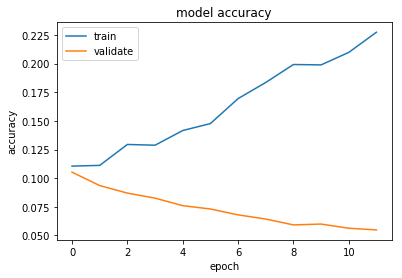

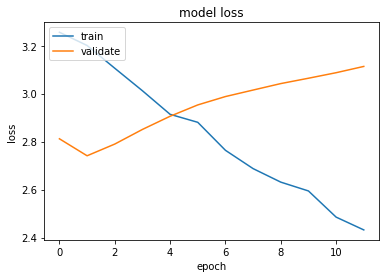

Train on 3122 samples, validate on 1369 samples
Epoch 1/1
3122/3122 [==============================] - 0s - loss: 2.4203 - acc: 0.2309 - val_loss: 3.1366 - val_acc: 0.0504
ll_model.optimizer.lr: 1e-07
train_last_layer, model just created from Vgg16(), # layers =  38
@ end of train_last_layer, # layers =  38
Number of layers :  38
0 <class 'keras.layers.core.Lambda'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) , len(weights) 0 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) , len(weights) 0 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) , len(weights) 2 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) , len(weights) 0 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 64,

count: 3
l1: <keras.layers.core.Dropout object at 0x7f231e077110>
l2: <keras.layers.core.Dropout object at 0x7f231e2aebd0>
l1.get_weights(): 0
l2.get_weights(): 0
count: 4
l1: <keras.layers.normalization.BatchNormalization object at 0x7f231e077150>
l2: <keras.layers.normalization.BatchNormalization object at 0x7f231e1cac10>
l1.get_weights(): 4
l2.get_weights(): 4
count: 5
l1: <keras.layers.core.Dropout object at 0x7f231e0771d0>
l2: <keras.layers.core.Dropout object at 0x7f231e2b4610>
l1.get_weights(): 0
l2.get_weights(): 0
count: 6
l1: <keras.layers.core.Dense object at 0x7f231e077210>
l2: <keras.layers.core.Dense object at 0x7f231e26f350>
l1.get_weights(): 2
l2.get_weights(): 2
marker AA
Train on 3122 samples, validate on 1369 samples
Epoch 1/2
3122/3122 [==============================] - 5s - loss: 2.3107 - acc: 0.2966 - val_loss: 0.6170 - val_acc: 0.8232
Epoch 2/2
3122/3122 [==============================] - 5s - loss: 0.9527 - acc: 0.6931 - val_loss: 0.2975 - val_acc: 0.9343
marker

3122/3122 [==============================] - 117s - loss: 1.5185 - acc: 0.5077 - val_loss: 0.2468 - val_acc: 0.9350
Epoch 2/8
3122/3122 [==============================] - 116s - loss: 1.1898 - acc: 0.5993 - val_loss: 0.2151 - val_acc: 0.9452
Epoch 3/8
3122/3122 [==============================] - 116s - loss: 0.9669 - acc: 0.6813 - val_loss: 0.1833 - val_acc: 0.9533
Epoch 4/8
3122/3122 [==============================] - 116s - loss: 0.8552 - acc: 0.7293 - val_loss: 0.1638 - val_acc: 0.9591
Epoch 5/8
3122/3122 [==============================] - 116s - loss: 0.7185 - acc: 0.7723 - val_loss: 0.1595 - val_acc: 0.9627
Epoch 6/8
3122/3122 [==============================] - 116s - loss: 0.6370 - acc: 0.8011 - val_loss: 0.1499 - val_acc: 0.9627
Epoch 7/8
3122/3122 [==============================] - 116s - loss: 0.5520 - acc: 0.8232 - val_loss: 0.1451 - val_acc: 0.9591
Epoch 8/8
3122/3122 [==============================] - 116s - loss: 0.5021 - acc: 0.8360 - val_loss: 0.1259 - val_acc: 0.9679
hi

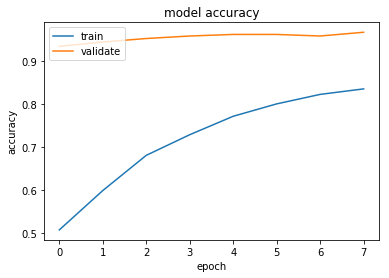

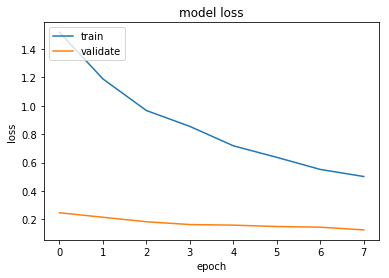

Epoch 1/10
3122/3122 [==============================] - 117s - loss: 0.4598 - acc: 0.8479 - val_loss: 0.1211 - val_acc: 0.9657
Epoch 2/10
3122/3122 [==============================] - 116s - loss: 0.3981 - acc: 0.8770 - val_loss: 0.1002 - val_acc: 0.9730
Epoch 3/10
3122/3122 [==============================] - 116s - loss: 0.3853 - acc: 0.8799 - val_loss: 0.0998 - val_acc: 0.9766
Epoch 4/10
 256/3122 [=>............................] - ETA: 75s - loss: 0.3324 - acc: 0.8906

In [ ]:
#build the ensemble
#multiple model builds, model trainings. takes long time.
for i in range(5):
    i = str(i)
    print ("i:", i)
    model = train_last_layer(i)
    #a tthis point, model = vgg16 model, minus last three layers, plus layers BatchNormalization + Dropout + Dense
    #get_ll_layers:create 3 layers, BatchNormalization + Dropout + Dense
    #train_last_layer uses get_ll_layers to create 3 layer model, trains it, then pops last 3 layers from vgg16model
    #at end of train_last_layer model has 38 layers with last three layers being BatchNormalization + Dropout + Dense

    train_dense_layers(i, model)

In [ ]:
for i in range(5):
    print (MODEL_PATH + s_or_p + 'aug' + str(i) + '.h5')

In [ ]:
ens_model2 = train_last_layer(str(11))

In [ ]:
for layer in ens_model2.layers: layer.trainable=True

In [ ]:
def get_ens_pred(arr, fname):
    ens_pred = []
    for i in range(5):
        i = str(i)
        print ("loading weights file:", i)
        ens_model2.load_weights('{}{}{}.h5'.format(MODEL_PATH, fname, i))
        print ("predicting from weights file:", i)
        preds = ens_model2.predict(arr, batch_size=batch_size)
        ens_pred.append(preds)
        print ("len(ens_pred):", len(ens_pred), ", len(preds):", len(preds))
    return ens_pred

In [ ]:
#recall: val = get_data(WORKING_VALID)
#val: (1500, 3, 224, 224)

val_pred2 = get_ens_pred(val, 'aug')
#nb: this loads weights from the files with 'aug' in filename. this is the final model build in method train_dense_layers

In [ ]:
print ("len(val_pred2):", len(val_pred2))
print(val_pred2[0].shape)
print(val_pred2[0][0:10, :])

In [ ]:
#calc categorical_accuracy for each prediction and for the average.
cat_acc = []
for i in range(5):
    temp_val_preds = val_pred2[i]
    print ("i:", i, type(temp_val_preds), temp_val_preds.shape)
    cat_acc.append(float(categorical_accuracy(val_labels, temp_val_preds).eval()))
    print ("i:", i, type(temp_val_preds), temp_val_preds.shape, ", categorical accuracy:", cat_acc[i])
print ("cat_acc:", type(cat_acc), cat_acc)


In [ ]:
val_avg_preds2 = np.stack(val_pred2).mean(axis=0)
#get the mean prediction across all 
print ("type(val_avg_preds2):", type(val_avg_preds2), val_avg_preds2.shape)
print(val_avg_preds2[0:10, :])

In [ ]:
print ("categorical accuracy from mean      :", float(categorical_accuracy(val_labels, val_avg_preds2).eval()))
print ("best individual categorical accuracy:", np.max(cat_acc))
#NB: mean accuracy is higher because it is choosing the best prediction row by row. then comparing with actual category.

In [ ]:
#recall: test = get_data(WORKING_TEST)
#<type 'numpy.ndarray'> (2500, 3, 224, 224)
startTime= datetime.now()
print ("startTime:", startTime)

test_pred2 = get_ens_pred(test, 'aug')

timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))


#print ("test_pred2.shape:", test_pred2.shape)
#approx time to run : production version: 

In [ ]:
print ("len(val_pred2):", len(test_pred2))
print(test_pred2[0].shape)


In [ ]:
print(test_pred2[0][0:10, :])

In [ ]:
avg_test_pred2 = np.stack(test_pred2).mean(axis=0)
#get the mean prediction across all 
print ("type(avg_test_pred2):", type(avg_test_pred2), avg_test_pred2.shape)
print(avg_test_pred2[0:10, :])

In [ ]:
avg_test_pred2 = avg_test_pred2[:,1]
print ("type(avg_test_pred2):", type(avg_test_pred2), avg_test_pred2.shape)

In [ ]:
#NB: need to check last few block suit 10 category predictions and output format required for kaggle submisison.

In [ ]:
#Submission : must have 79726 rows